In [33]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from torchvision import datasets ,models,transforms
import os
import matplotlib.image as img

from torch.utils.data import Dataset, DataLoader
#from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module

import pickle
import math
from app_Cupy import *
import tqdm
from tqdm import trange


In [35]:
# def Sigmoid(x):
#     x = cp.clip(x, -500, 500)
#     return 1. /(1 + cp.exp(-x))

In [36]:
import app_Cupy
import importlib
importlib.reload(app_Cupy)
from app_Cupy import *

In [37]:
#run numpy on gpu
import cupy as cp

# Load data

In [38]:
with open('../data_pickle/resized_train_data.pickle', 'rb') as f :
    train = pickle.load(f)
with open('../data_pickle/resized_valid_data.pickle', 'rb') as f :
    valid = pickle.load(f)
with open('../data_pickle/resized_test_data.pickle', 'rb') as f :
    test = pickle.load(f)

In [39]:
X_train = np.array(train['train_data'])
Y_train = np.array(train['train_label'])
X_val = np.array(valid['valid_data'])
Y_val = np.array(valid['valid_label'])
X_test = np.array(test['test_data'])
Y_test = np.array(test['test_label'])

In [40]:
X_train = cp.transpose(X_train,(0,3,1,2))
X_val = cp.transpose(X_val,(0,3,1,2))
X_test = cp.transpose(X_test,(0,3,1,2))


In [11]:
X_train.shape, type(X_train)

((63325, 3, 64, 64), numpy.ndarray)

In [12]:
Y_train = cp.array(Y_train)
Y_val = cp.array(Y_val)
Y_test = cp.array(Y_test)

In [53]:
class LeNet5_improved(Net):
    # LeNet5

    def __init__(self):
        #self.conv1 = Conv(3, 6, 3)  #64>62
        self.conv1 = Conv(3, 6, 64, 64, 3, 1, 0)
        self.Sigmoid1 = Sigmoid()
        self.pool1 = MaxPool(2,2)   #62>31
        #self.conv2 = Conv(6, 16, 4)  #31>28
        self.conv2 = Conv(6, 16, 31, 31, 4, 1, 0)
        self.Sigmoid2 = Sigmoid()
        self.pool2 = MaxPool(2,2) #28>14
        self.FC1 = FC(16*14*14, 512)
        self.Sigmoid3 = Sigmoid()
        self.FC2 = FC(512, 256)
        self.Sigmoid4 = Sigmoid()
        self.FC3 = FC(256, 128)
        self.Sigmoid5 = Sigmoid()
        self.FC4 = FC(128, 50)
        self.Softmax = Softmax()

        self.p2_shape = None
        


    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.Sigmoid1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.Sigmoid2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.Sigmoid3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.Sigmoid4._forward(h4)
        h5 = self.FC3._forward(a5)
        #add layer
        a6 = self.Sigmoid5._forward(h5)
        h6 = self.FC4._forward(a6)
        
        a7 = self.Softmax._forward(h6)
        return a7

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        #add layer
        dout = self.FC4._backward(dout)
        dout = self.Sigmoid5._backward(dout)
        
        dout = self.FC3._backward(dout)
        dout = self.Sigmoid4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.Sigmoid3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.Sigmoid2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.Sigmoid1._backward(dout)
        dout = self.conv1._backward(dout)
   
    
    def accuracy(self, x, t, k ):
        y = self.forward(x)
        y_hat_k = y.argsort(axis=1)[:,-k:]
        #y = np.argmax(y, axis=1)
        #if t.ndim != 1 : t = np.argmax(t, axis=1)
        #accuracy = np.sum(y == t) / float(x.shape[0])
        #y = np.argmax(y, axis=1)
        #t = np.argmax(t, axis=1)
        y_hat_k = y.argsort(axis=1)[:,-k:]
        lst = []
        for i in range(len(t)):
            lst.append(t[i] in y_hat_k[i,:])
        accuracy = np.mean(lst)
        return accuracy


    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params


In [54]:
model = LeNet5_improved()
losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

OutOfMemoryError: Out of memory allocating 12,845,056 bytes (allocated so far: 66,867,200 bytes).

In [27]:
batch_size = 100

In [23]:
from tqdm import trange

In [25]:
# Y_val_one = MakeOneHot(Y_val, 50)
# Y_test_one = MakeOneHot(Y_test, 50)

In [52]:
train_acc_list = []
valid_acc_list = []
test_acc_list = []
train_acc_5_list = []
valid_acc_5_list = []
test_acc_5_list = []
ITER = 5000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    X_batch = cp.array(X_batch)
    #X_batch = cp.transpose(X_batch,(0,3,1,2))
#     X_val = cp.transpose(X_val,(0,3,1,2))
#     X_test = cp.transpose(X_test,(0,3,1,2))
    Y_batch_OneHot = MakeOneHot(Y_batch, 50)
    #Y_batch = cp.array(Y_batch)

    # forward, loss, backward, step
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch_OneHot)
    
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        #print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)
              
        train_acc = model.accuracy(X_batch, Y_batch, k= 1) 
        valid_acc = model.accuracy(X_val, Y_val, k= 1)  
        test_acc = model.accuracy(X_test, Y_test, k= 1)
        
        
        train_acc_5 = model.accuracy(X_batch, Y_batch, k= 5) 
        valid_acc_5 = model.accuracy(X_val, Y_val, k= 5)  
        test_acc_5 = model.accuracy(X_test, Y_test, k= 5)
        
        train_acc_list.append(train_acc) 
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)     
        
        train_acc_5_list.append(train_acc_5) 
        valid_acc_5_list.append(valid_acc_5)
        test_acc_5_list.append(test_acc_5)
        #print("train acc, valid acc , test acc| " + str(train_acc) + ", " + str(valid_acc) + ", " + str(test_acc)+'；' +"train acc_5, valid acc_5, test acc_5| " + str(train_acc_5) + ", " + str(valid_acc_5) + ", " + str(test_acc_5))
        print("epochs：{},acc-top1 train：{:.6}, valid：{} , test：{} ".format(i, train_acc.item(),valid_acc.item(),test_acc.item())+'；' 
              +"acc-top5 train：{:.6}, valid：{}, test：{} ".format(train_acc_5.item(), valid_acc_5.item(), test_acc_5.item())
                +" loss: %s" % (loss))



# save params
weights = model.get_params()
with open("weights1.pkl","wb") as f:
    pickle.dump(weights, f)


draw_losses(losses)

OutOfMemoryError: Out of memory allocating 9,830,400 bytes (allocated so far: 67,182,080 bytes).

In [245]:
# def draw_losses(losses):
#     t = cp.arange(len(losses)).get()
#     plt.plot(t, losses)
#     plt.show()

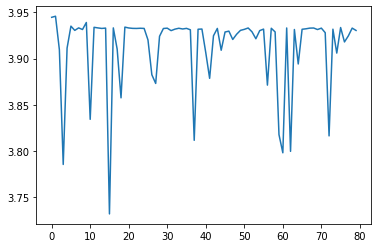

In [353]:
draw_losses(losses)

In [355]:

# TEST SET ACC
#X_test = cp.transpose(X_test,(0,3,1,2))
Y_pred = model.forward(X_test)
result = cp.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


TEST--> Correct: 9 out of 450, acc=0.02


In [341]:
y_hat_k = y.argsort(axis=1)[:,-k:]
lst = []
for i in range(len(Y_test)):
    lst.append(Y_test[i] in y_hat_k[i,:])
acc = np.mean(lst)
acc

0.1

In [261]:
import matplotlib.pylab as plt
import seaborn as sns

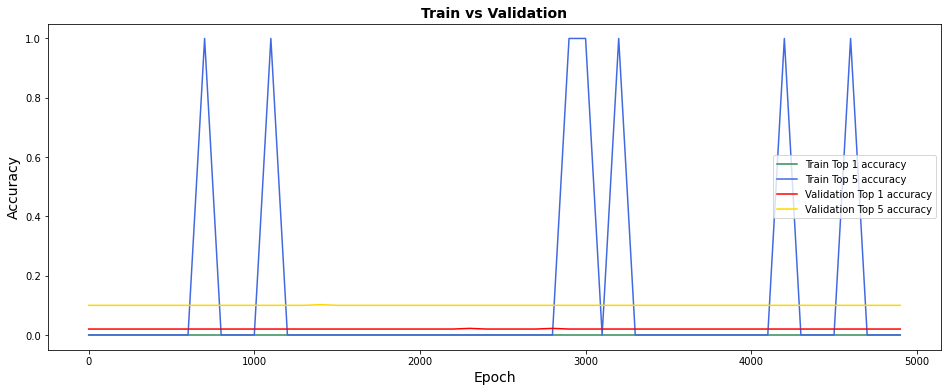

In [356]:
x = np.arange(0, 5000, 100)
#x = cp.arange(len(train_acc_list)).get()
fig = plt.figure()
#x = list(range(0, len(train_acc) * 50, 50))
ax = sns.lineplot(x = x, y = train_acc_list, color='seagreen', label = 'Train Top 1 accuracy')
sns.lineplot(x = x, y = train_acc_5_list, color='royalblue', label = 'Train Top 5 accuracy')
sns.lineplot(x = x, y = valid_acc_list, color='red', label = 'Validation Top 1 accuracy')
sns.lineplot(x = x, y = valid_acc_5_list, color='gold', label = 'Validation Top 5 accuracy')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Accuracy", size = 14)
ax.set_title("Train vs Validation", size = 14, fontweight='bold')
ax.legend()
fig.set_figheight(6)
fig.set_figwidth(16)